In [1]:
import matplotlib.pyplot as plt
from matplotlib import patches
import astropy.units as u
from astropy.coordinates import SkyCoord

import glob
import rawpy

from PIL import Image
from datetime import datetime

import exifread
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
sys.executable

'/Users/oliveros/anaconda/bin/python'

In [5]:
infiles = glob.glob('../Igor/D500/*NEF')

from jupyter_core.paths import jupyter_data_dir
print(jupyter_data_dir())

/home/oliveros/.local/share/jupyter


In [4]:
f = open('img_info.txt', 'w')
g = []

for infile in infiles:
    #print(infile)
    tags = exifread.process_file(open(infile, 'rb'))

    if "EXIF ExposureTime" in tags:
        exposure_tag = tags['EXIF ExposureTime']
        exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
        #print("Exposure time of {0} found!".format(exposure_time))

    if "EXIF DateTimeOriginal" in tags:
        datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
        time = datetime(int(datetime_str[0]), int(datetime_str[1]),
                        int(datetime_str[2]), int(datetime_str[3]),
                        int(datetime_str[4]), int(datetime_str[5]))
        #print("Image time of {0} found!".format(str(time)))
        
    f.write('%s \t %s \t %s \n'%(infile,exposure_time,str(time)))
    g.append([infile,exposure_time,time])
    #print('%s \t %s \t %s'%(infile,exposure_time,str(time)))
    
    
    #raw = rawpy.imread(infile)
    #rgb = raw.postprocess()
    
    #img = Image.fromarray(rgb) # Pillow image
    #img.show()
    
f.close()

NameError: name 'exifread' is not defined

In [5]:
if "EXIF ExposureTime" in tags:
    exposure_tag = tags['EXIF ExposureTime']
    exposure_time = exposure_tag.values[0].num / exposure_tag.values[0].den * u.s
    print("Exposure time of {0} found!".format(exposure_time))

if "EXIF DateTimeOriginal" in tags:
    datetime_str = tags['EXIF DateTimeOriginal'].values.replace(' ', ':').split(':')
    time = datetime(int(datetime_str[0]), int(datetime_str[1]), 
                    int(datetime_str[2]), int(datetime_str[3]),
                    int(datetime_str[4]), int(datetime_str[5]))
    print("Image time of {0} found!".format(str(time)))

NameError: name 'tags' is not defined

In [6]:
g_sorted = sorted(g, key=lambda gitem: gitem[1]) 

In [7]:
for gs in g_sorted:
    if gs[1].value == 0.025:
        print(gs)


In [13]:
from numpy import *

def histeq(im,nbr_bins=256):
  """  Histogram equalization of a grayscale image. """

  # get image histogram
  imhist,bins = histogram(im.flatten(),nbr_bins,normed=True)
  cdf = imhist.cumsum() # cumulative distribution function
  cdf = 255 * cdf / cdf[-1] # normalize

  # use linear interpolation of cdf to find new pixel values
  im2 = interp(im.flatten(),bins[:-1],cdf)

  return im2.reshape(im.shape), cdf


0 ['../Igor/D500/DSC_5575.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 37)]
1 ['../Igor/D500/DSC_5588.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 37, 17)]


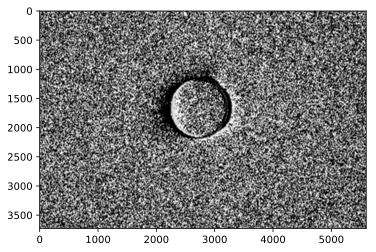

2 ['../Igor/D500/DSC_5637.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 38, 21)]


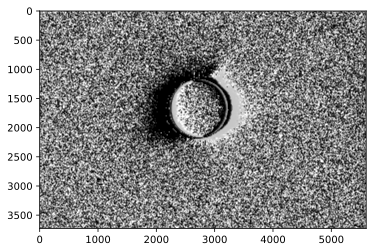

3 ['../Igor/D500/DSC_5650.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 38, 38)]


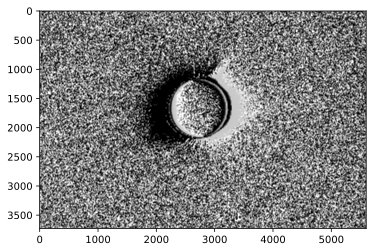

4 ['../Igor/D500/DSC_5665.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 38, 51)]


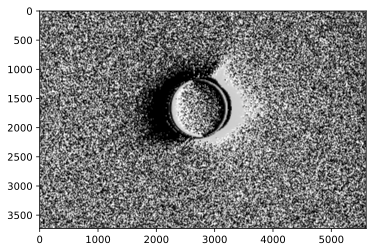

5 ['../Igor/D500/DSC_5668.NEF', <Quantity 0.025 s>, datetime.datetime(2017, 8, 21, 17, 38, 53)]


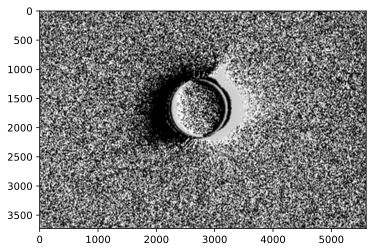

In [83]:
counter = 0
for gs in g_sorted:
    if gs[1].value == 0.025:
        print(counter,gs)
        if counter == 0:
            raw = rawpy.imread(gs[0])
            rgb0 = raw.postprocess()
            
            img0 = Image.fromarray(rgb0) # Pillow image
        else:
            raw = rawpy.imread(gs[0])
            rgb1 = raw.postprocess()
            
            img1 = Image.fromarray(rgb1) # Pillow image
            
            rgb = rgb1 - rgb0
            img = Image.fromarray(rgb) # Pillow image
            
            im = array(img.convert('L'))
            im[im<10] = 0

            im2,cdf = histeq(im)

            plt.imshow(im2,cmap='gray')
            plt.show()
            
            img0=img1
        counter = counter+1

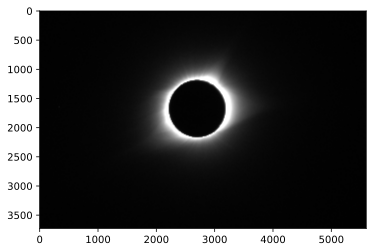

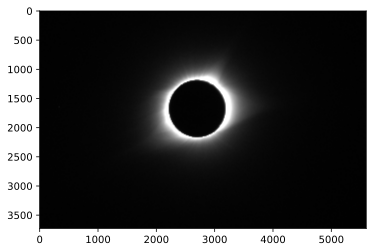

/Users/oliveros/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


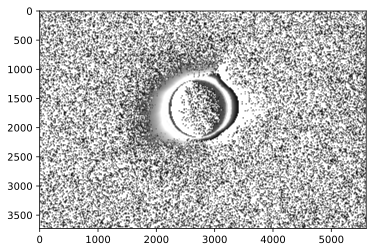

In [81]:
import cv2

# Read the images to be aligned
#im1 =  cv2.imread("images/image1.jpg");
#im2 =  cv2.imread("images/image2.jpg");
 
# Convert images to grayscale
#im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
#im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)

im1_gray = cv2.cvtColor(np.array(img0),cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(np.array(img1),cv2.COLOR_BGR2GRAY)

# Find size of image1
sz = im1_gray.shape
 
# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION
 
# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)
 
# Specify the number of iterations.
number_of_iterations = 5000;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;
 
# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
 
# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)
 
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    # Use warpPerspective for Homography 
    im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR)# + cv2.WARP_INVERSE_MAP)
else :
    # Use warpAffine for Translation, Euclidean and Affine
    im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR );#+ cv2.WARP_INVERSE_MAP);
 
# Show final results
plt.imshow(im1_gray,cmap='gray')
plt.show()
plt.imshow(im2_gray,cmap='gray')
plt.show()

image3 = im1_gray - im2_aligned
image3[image3<-100] = np.nan
image3[image3>100] = np.nan
plt.imshow(image3,cmap='gray')
plt.show()



In [34]:
g_sorted

[['../Igor/D500/DSC_5565.NEF',
  <Quantity 0.00015625 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 50)],
 ['../Igor/D500/DSC_5567.NEF',
  <Quantity 0.00015625 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 52)],
 ['../Igor/D500/DSC_5676.NEF',
  <Quantity 0.00015625 s>,
  datetime.datetime(2017, 8, 21, 17, 39, 2)],
 ['../Igor/D500/DSC_5678.NEF',
  <Quantity 0.00015625 s>,
  datetime.datetime(2017, 8, 21, 17, 39, 4)],
 ['../Igor/D500/DSC_5680.NEF',
  <Quantity 0.00015625 s>,
  datetime.datetime(2017, 8, 21, 17, 39, 6)],
 ['../Igor/D500/DSC_5554.NEF',
  <Quantity 0.0002 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 34)],
 ['../Igor/D500/DSC_5556.NEF',
  <Quantity 0.0002 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 41)],
 ['../Igor/D500/DSC_5557.NEF',
  <Quantity 0.0002 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 43)],
 ['../Igor/D500/DSC_5559.NEF',
  <Quantity 0.0002 s>,
  datetime.datetime(2017, 8, 21, 17, 36, 44)],
 ['../Igor/D500/DSC_5560.NEF',
  <Quantity 0.0002 s>,
  datetime.datetime(

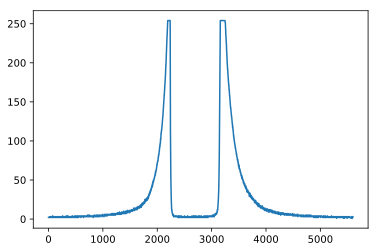

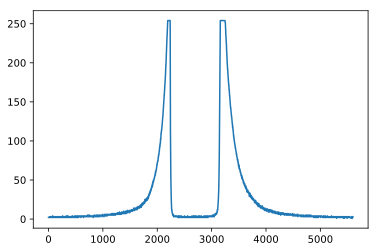

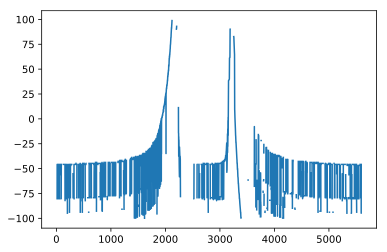

In [82]:
plt.plot(im1_gray[1500,:])
plt.show()

plt.plot(im2_gray[1500,:])
plt.show()

plt.plot(image3[1500,:])
plt.show()
